# Lesson 5 - Other Datasets

<br/>

### Import the necessary python libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import rasterio
from sklearn.linear_model import LinearRegression

In [2]:
## bring in LiDAR data for Boulder Downtown
dataset_terrain = rasterio.open("./data/BoulderDowntown.dtm.tif")
dataset_surface = rasterio.open("./data/BoulderDowntown.dsm.tif")
band1_terrain = dataset_terrain.read(1)
band1_surface = dataset_surface.read(1)
## set map and LiDAR bounds
left, bottom, right, top = dataset_terrain.bounds
# print(left, bottom, right, top)
left_deg, bottom_deg, right_deg, top_deg = (-105.2926705, 40.0131655, -105.2618917, 40.0230239)
## for converting lat and long degrees into meters (same as lesson 2)
meters_per_lat = 111319.49 
meters_per_long = 85263.24 ## only valid at latitudes of 40 degrees

In [3]:
## bring in LiDAR data for Boulder Downtown
gm_dataset_terrain = rasterio.open("./data/GreenMesa.dtm.tif")
gm_band1_terrain = gm_dataset_terrain.read(1)
## set map and LiDAR bounds
gm_left, gm_bottom, gm_right, gm_top = dataset_terrain.bounds
gm_left_deg, gm_bottom_deg, gm_right_deg, gm_top_deg = (-105.2791896, 39.9886473, -105.2697077, 39.9931116)

In [4]:
## takes a lat, long coordinate pair
##  and returns a meters based coordinate pair
def convert_gps_to_meters(lat, long):
    lat_dif = top_deg - lat
    long_dif = long - left_deg
    vert_dif_m = lat_dif * meters_per_lat
    horz_dif_m = long_dif * meters_per_long
    return (vert_dif_m, horz_dif_m)

## get_elev function finds the elevation of a Latitude and Longitude location 
##  takes lat and long of the location, lidar dataset (DSM or DTM), and the lidar band that holds elevation
def get_elev(lat, long, lidar_model, lidar_elev_band):
    vert_dif_m, horz_dif_m = convert_gps_to_meters(lat, long)
    row, col = lidar_model.index(left + horz_dif_m, top - vert_dif_m) ## get the row and colomn where the elevation is stored
    elev = lidar_elev_band[row][col] ## retrieve the elevation
    return elev

## set Boudler Downtown center location
bd_center = (40.01778,-105.27783)
bd_center_meters = convert_gps_to_meters(bd_center[0], bd_center[1])

In [5]:
print("Example Point is at x = {:.2f}, y = {:.2f} (in meters). The origin is the top left corner of the map.".format(bd_center_meters[1], bd_center_meters[0]))

Example Point is at x = 1265.35, y = 583.75 (in meters). The origin is the top left corner of the map.


In [6]:
xmid = bd_center_meters[1]
ymid = bd_center_meters[0]
radius = 300
## generate 1000 random x,y locations near the Martin Acres center
x_random = np.random.randint(xmid-radius, xmid+radius, 10000)
y_random = np.random.randint(ymid-radius, ymid+radius, 10000)

## create lists to hold the locations and clutter heights that are within 500 meters of the Example Point
within_500m_x = []
within_500m_y = []
clutter_height_ls = []

## loop through all of the random points
for i in range(len(x_random)):
    ## find distance from Example Point to a random point
    distance = np.sqrt(np.square(bd_center_meters[1]-x_random[i]) + np.square(bd_center_meters[0]-y_random[i]))
    
    ## if distance is within 500 meters, find the clutter height at that location
    if distance < radius:
        ground_elev = band1_terrain[y_random[i]][x_random[i]]
        clutter_elev = band1_surface[y_random[i]][x_random[i]]
        clutter_height = clutter_elev - ground_elev
        ## clutter must be higher than 2 meters to be considered "clutter"
        if clutter_height > 2:
            clutter_height_ls.append(clutter_height)
            within_500m_x.append(x_random[i])
            within_500m_y.append(y_random[i])

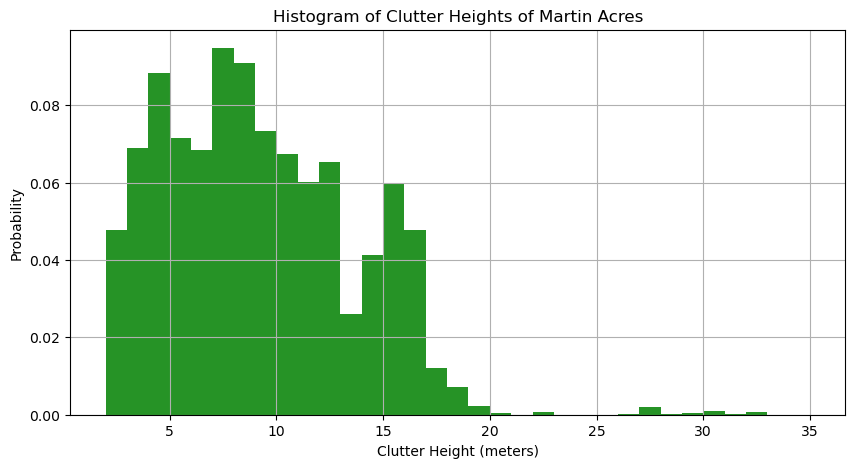

In [7]:
plt.rcParams["figure.figsize"] = (10,5)

# the histogram of the data
n, bins, patches = plt.hist(clutter_height_ls, np.linspace(2,35,34), density=True, facecolor='g', alpha=.85)


plt.xlabel('Clutter Height (meters)')
plt.ylabel('Probability')
plt.title('Histogram of Clutter Heights of Martin Acres')
plt.grid(True)
plt.show()

In [8]:
print("Boulder Downtown Clutter Heights:\n Mean = {:.1f} meters\n Median = {:.1f} meters\n Standard Deviation = {:.1f} meters".format(np.mean(clutter_height_ls),
                                                                                                                         np.median(clutter_height_ls),
                                                                                                                         np.std(clutter_height_ls)))

bd_clutter_height_mean = np.mean(clutter_height_ls)
bd_clutter_height_std = np.std(clutter_height_ls)

Boulder Downtown Clutter Heights:
 Mean = 9.2 meters
 Median = 8.7 meters
 Standard Deviation = 4.5 meters


In [9]:
BoulderDowntown_name = "./data/Boulder_Downtown_GreenMesa_3475_20230303.Downtown.csv"
# BoulderDowntown_name = "./data/Boulder_Downtown_GreenMesa_3475_20230303.csv"
bd_df = pd.read_csv(BoulderDowntown_name)
# bd_df = temp_df.loc[temp_df["RxLat"] > 40.0141]

In [10]:
bd_df.head(5)

,ID,TxLat,TxLon,RxLat,RxLon,h_tx__meter,h_rx__meter,f__mhz,d__km,L_meas__db,L_fs__db,L_excess__db,Cnt,Sigma__db
0,9237,39.992311,-105.273167,40.016593,-105.286227,19.2,2.82,3475,2.917706,129.328639,112.569927,16.758712,1,0.0
1,9238,39.992311,-105.273167,40.016594,-105.286221,19.2,2.82,3475,2.917613,129.235992,112.569649,16.666343,1,0.0
2,9239,39.992311,-105.273167,40.016595,-105.286216,19.2,2.82,3475,2.917552,129.177610,112.569469,16.608141,1,0.0
3,9240,39.992311,-105.273167,40.016596,-105.286211,19.2,2.82,3475,2.917492,129.377112,112.569289,16.807823,1,0.0
4,9241,39.992311,-105.273167,40.016597,-105.286205,19.2,2.82,3475,2.917399,129.995244,112.569013,17.426231,1,0.0


In [11]:
## functions to convert lat and long to meters
def convert_lat_to_meters(lat):
    lat_dif = top_deg - lat
    vert_dif_m = lat_dif * meters_per_lat
    return vert_dif_m

def convert_long_to_meters(long):
    long_dif = long - left_deg
    horz_dif_m = long_dif * meters_per_long
    return horz_dif_m

## create new columns by mapping the conversion function to lat or long column
bd_df["RxX__meter"] = bd_df["RxLon"].map(convert_long_to_meters)
bd_df["RxY__meter"] = bd_df["RxLat"].map(convert_lat_to_meters)
# bd_df["TxX__meter"] = bd_df["TxLon"].map(convert_long_to_meters)
# bd_df["TxY__meter"] = bd_df["TxLat"].map(convert_lat_to_meters)

# 39.992311

gm_TxX__meter = (bd_df["TxLon"][0] - gm_left_deg) * meters_per_long
gm_TxY__meter = (gm_top_deg - bd_df["TxLat"][0]) * meters_per_lat


In [12]:
## use LiDAR to add antenna altitude to the dataframes for TX and RX antenna
def antenna_altitude(x, y, antenna_height, lidar_elev_band):
    elev = lidar_elev_band[int(y)][int(x)]
    return elev + antenna_height

bd_df["alt_rx__meter"] = bd_df.apply(lambda row: antenna_altitude(row.RxX__meter, row.RxY__meter, row.h_rx__meter, band1_terrain), axis=1)
bd_df["alt_tx__meter"] = bd_df.apply(lambda row: antenna_altitude(gm_TxX__meter, gm_TxY__meter, row.h_tx__meter, gm_band1_terrain), axis=1)

## RX elevation angle = arcsin( (tx_altitude - rx_altitude) / Hypotenuse distance )
##  returns Rx elevation angle in degrees
def rx_elev_angle(alt_rx, alt_tx, d):
    soh = np.abs(alt_tx - alt_rx) / (d*1000)
    angle_deg = np.arcsin(soh)*360/(np.pi*2) 
    return angle_deg

## calculate the rx antenna angle and add a new column to the dataframe
bd_df["rx_angle__deg"] = bd_df.apply(lambda row: rx_elev_angle(row.alt_rx__meter, row.alt_tx__meter, row.d__km), axis=1)

In [13]:
def convert_gps_to_meters(lat, long):
    lat_dif = top_deg - lat
    long_dif = long - left_deg
    vert_dif_m = lat_dif * meters_per_lat
    horz_dif_m = long_dif * meters_per_long
    return (vert_dif_m, horz_dif_m)

In [14]:
h_c = bd_clutter_height_mean + 2*bd_clutter_height_std

def clutter_distance(rep_clutter_height, rx_angle):
    return rep_clutter_height/np.sin(rx_angle*(2*np.pi)/360) ## 2*pi/360 converts from degrees to radians

## add the new clutter distance columns
bd_df["clutter_d__meter"] = bd_df.apply(lambda row: clutter_distance(h_c, row.rx_angle__deg), axis=1)

In [15]:
## perform the linear regression on the data
linear_regression = LinearRegression()
linear_regression.fit(np.array(np.log10(bd_df["clutter_d__meter"])).reshape(-1,1), bd_df["L_excess__db"])
y_int = linear_regression.intercept_
slope = linear_regression.coef_[0]
print("a = {:.2f} \nb = {:.2f}".format(slope, y_int))
print("L_cm = {:.2f} * log10(r_c) + {:.2f}".format(slope, y_int))

a = 78.06 
b = -182.59
L_cm = 78.06 * log10(r_c) + -182.59


### Plot with the fit line with the measurement data

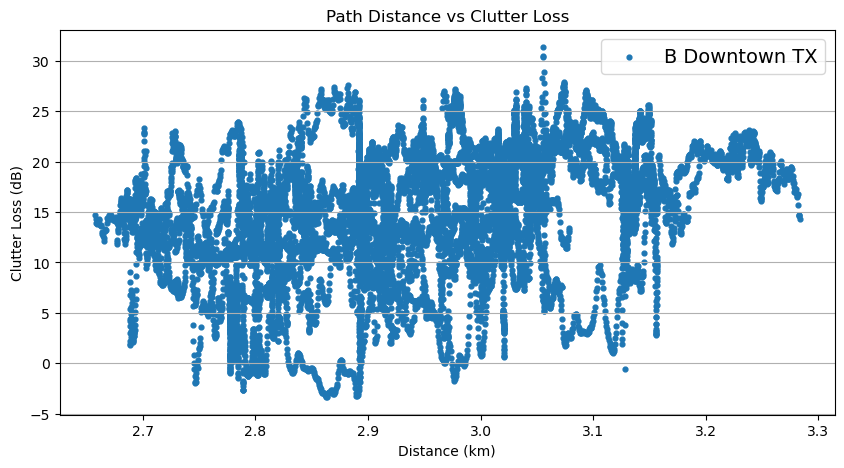

In [16]:
plt.scatter(bd_df["d__km"], bd_df["L_excess__db"], label='B Downtown TX', s=12)

plt.xlabel('Distance (km)')
plt.ylabel('Clutter Loss (dB)')
plt.title('Path Distance vs Clutter Loss')

plt.legend(fontsize=14)
plt.gca().yaxis.grid(True)
plt.show()

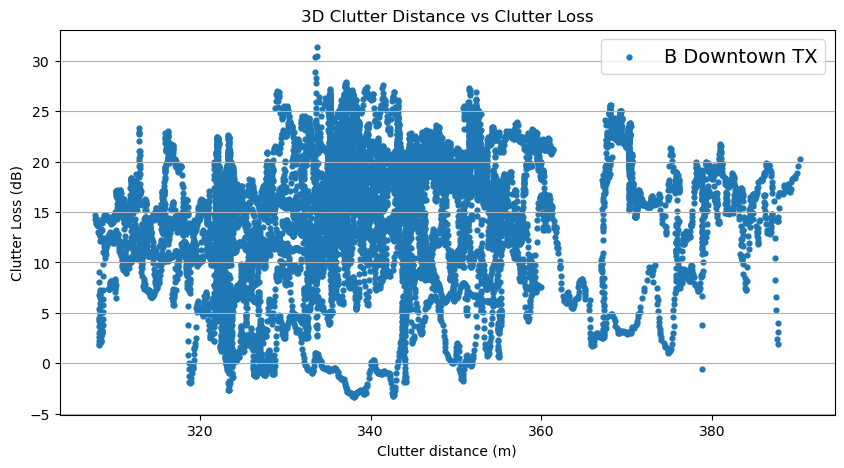

In [17]:
plt.scatter(bd_df["clutter_d__meter"], bd_df["L_excess__db"], label='B Downtown TX', s=12)

plt.xlabel('Clutter distance (m)')
plt.ylabel('Clutter Loss (dB)')
plt.title('3D Clutter Distance vs Clutter Loss')

plt.legend(fontsize=14)
plt.gca().yaxis.grid(True)
plt.show()

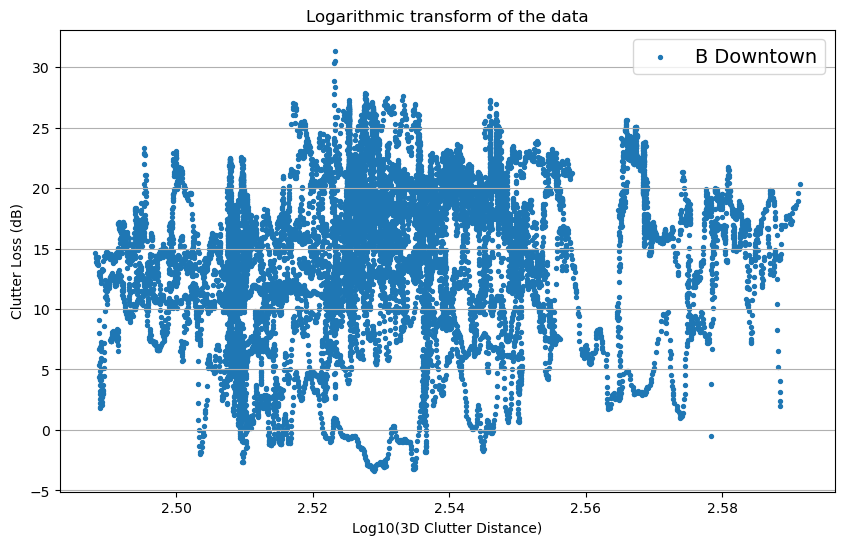

In [18]:
plt.rcParams["figure.figsize"] = (10,6)

## the x data now has a np.log10() function applied to it
plt.scatter(np.log10(bd_df["clutter_d__meter"]), bd_df["L_excess__db"], label='B Downtown', s=8, zorder=1)

plt.xlabel('Log10(3D Clutter Distance)')
plt.ylabel('Clutter Loss (dB)')
plt.title('Logarithmic transform of the data')
  
plt.legend(fontsize=14)
plt.gca().yaxis.grid(True)
plt.show()

In [19]:
y_int = -9.8
slope = 13.7
print("a = {:.2f} \nb = {:.2f}".format(slope, y_int))
print("L_cm = {:.2f} * log10(r_c) + {:.2f}".format(slope, y_int))

a = 13.70 
b = -9.80
L_cm = 13.70 * log10(r_c) + -9.80


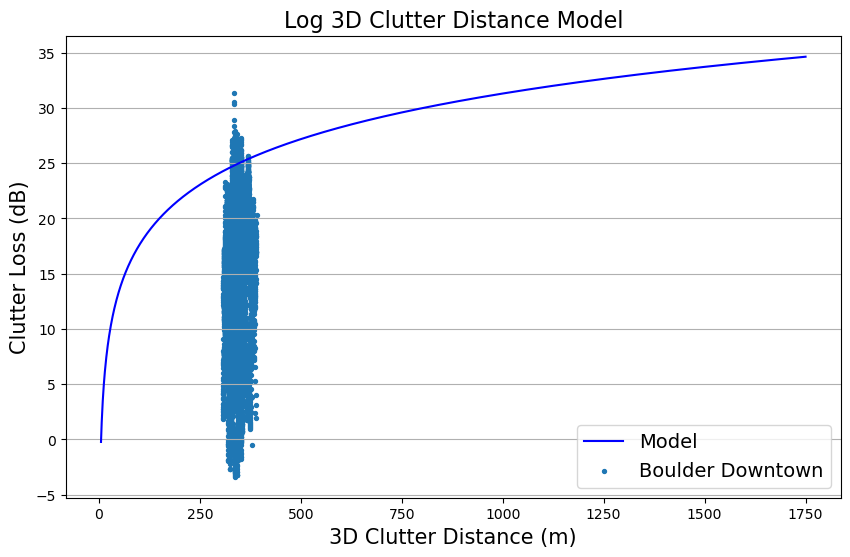

In [20]:
full_x = np.linspace(5,1750,2000)
full_y = slope*np.log10(full_x) + y_int
plt.plot(full_x, full_y, label='Model', c='b')

plt.scatter(bd_df["clutter_d__meter"], bd_df["L_excess__db"], label='Boulder Downtown', s=8)

plt.xlabel('3D Clutter Distance (m)', fontsize=15)
plt.ylabel('Clutter Loss (dB)', fontsize=15)
plt.title('Log 3D Clutter Distance Model', fontsize=16)
plt.legend(fontsize=14)
plt.gca().yaxis.grid(True)
plt.show()

In [21]:
drexel1 = "./data/Boulder_Drexel_GreenMesa_3475_20221216.Drexel.csv"
drexel2 = "./data/Boulder_Drexel_GreenMesa_3475_20230621.Drexel.csv"
drexel3 = "./data/Boulder_Drexel_NCAR_3475_20221216.Drexel.csv"
drexel4 = "./data/Boulder_Drexel_NCAR_3475_20230621.Drexel.csv"

drex1_df = pd.read_csv(drexel1)
drex2_df = pd.read_csv(drexel2)
drex3_df = pd.read_csv(drexel3)
drex4_df = pd.read_csv(drexel4)

drexfull_df = pd.concat([drex1_df, drex2_df, drex3_df, drex4_df])

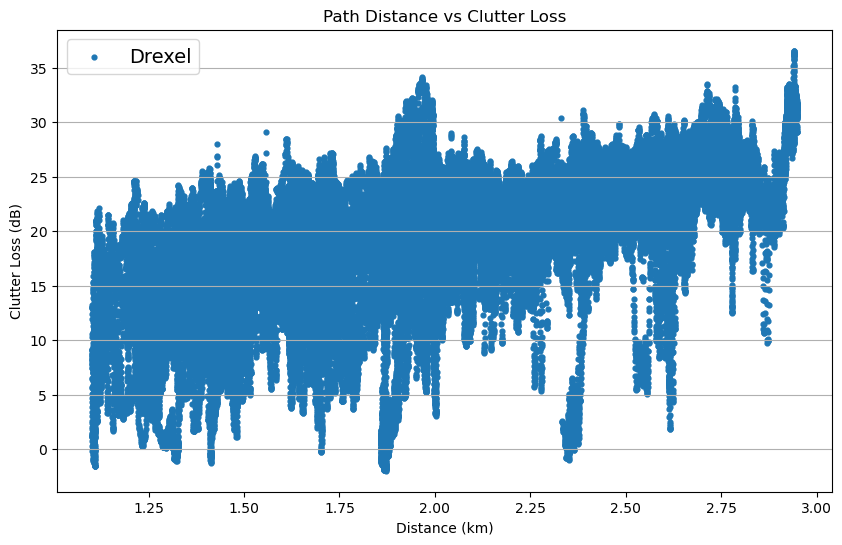

In [22]:
plt.rcParams["figure.figsize"] = (10,6)
plt.scatter(drexfull_df["d__km"], drexfull_df["L_excess__db"], label='Drexel', s=12)

plt.xlabel('Distance (km)')
plt.ylabel('Clutter Loss (dB)')
plt.title('Path Distance vs Clutter Loss')

plt.legend(fontsize=14)
plt.gca().yaxis.grid(True)
plt.show()

In [23]:
## bring in LiDAR data for Boulder Downtown
dataset_terrain = rasterio.open("./data/Drexel.dtm.tif")
dataset_surface = rasterio.open("./data/Drexel.dsm.tif")
band1_terrain = dataset_terrain.read(1)
band1_surface = dataset_surface.read(1)
## set map and LiDAR bounds
left, bottom, right, top = dataset_terrain.bounds
print(left, bottom, right, top)
left_deg, bottom_deg, right_deg, top_deg = (-105.2762749, 39.9687696, -105.2468325, 39.9936941)
## for converting lat and long degrees into meters (same as lesson 2)
meters_per_lat = 111319.49 
meters_per_long = 85263.24 ## only valid at latitudes of 40 degrees

476406.50000000093 4424327.5 478928.50000000093 4427086.5


In [24]:
## takes a lat, long coordinate pair
##  and returns a meters based coordinate pair
def convert_gps_to_meters(lat, long):
    lat_dif = top_deg - lat
    long_dif = long - left_deg
    vert_dif_m = lat_dif * meters_per_lat
    horz_dif_m = long_dif * meters_per_long
    return (vert_dif_m, horz_dif_m)

## get_elev function finds the elevation of a Latitude and Longitude location 
##  takes lat and long of the location, lidar dataset (DSM or DTM), and the lidar band that holds elevation
def get_elev(lat, long, lidar_model, lidar_elev_band):
    vert_dif_m, horz_dif_m = convert_gps_to_meters(lat, long)
    row, col = lidar_model.index(left + horz_dif_m, top - vert_dif_m) ## get the row and colomn where the elevation is stored
    elev = lidar_elev_band[row][col] ## retrieve the elevation
    return elev

## set Boudler Downtown center location
drexel_center = (39.97697,-105.25517)
drexel_center_meters = convert_gps_to_meters(drexel_center[0], drexel_center[1])

In [25]:
print("Example Point is at x = {:.2f}, y = {:.2f} (in meters). The origin is the top left corner of the map.".format(drexel_center_meters[1], drexel_center_meters[0]))

Example Point is at x = 1799.47, y = 1861.72 (in meters). The origin is the top left corner of the map.


In [26]:
xmid = drexel_center_meters[1]
ymid = drexel_center_meters[0]
radius = 500
## generate 1000 random x,y locations near the Martin Acres center
x_random = np.random.randint(xmid-radius, xmid+radius, 10000)
y_random = np.random.randint(ymid-radius, ymid+radius, 10000)

## create lists to hold the locations and clutter heights that are within 500 meters of the Example Point
within_500m_x = []
within_500m_y = []
clutter_height_ls = []

## loop through all of the random points
for i in range(len(x_random)):
    ## find distance from Example Point to a random point
    distance = np.sqrt(np.square(drexel_center_meters[1]-x_random[i]) + np.square(drexel_center_meters[0]-y_random[i]))
    
    ## if distance is within 500 meters, find the clutter height at that location
    if distance < radius:
        ground_elev = band1_terrain[y_random[i]][x_random[i]]
        clutter_elev = band1_surface[y_random[i]][x_random[i]]
        clutter_height = clutter_elev - ground_elev
        ## clutter must be higher than 2 meters to be considered "clutter"
        if clutter_height > 2:
            clutter_height_ls.append(clutter_height)
            within_500m_x.append(x_random[i])
            within_500m_y.append(y_random[i])

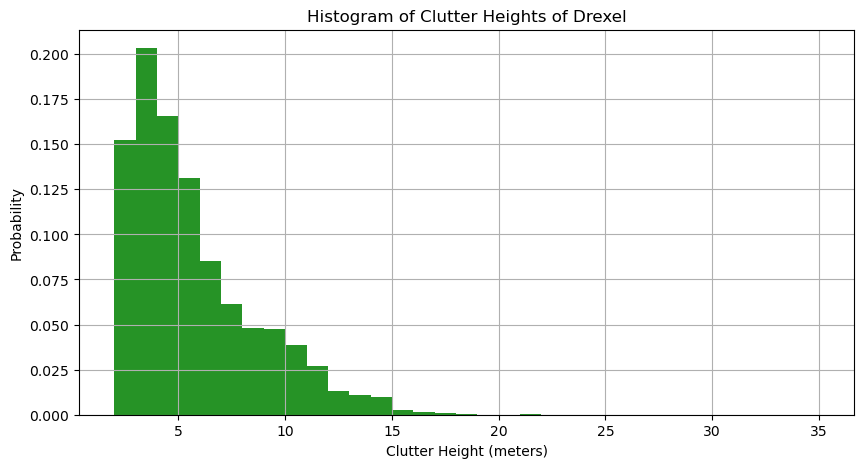

In [27]:
plt.rcParams["figure.figsize"] = (10,5)

# the histogram of the data
n, bins, patches = plt.hist(clutter_height_ls, np.linspace(2,35,34), density=True, facecolor='g', alpha=.85)


plt.xlabel('Clutter Height (meters)')
plt.ylabel('Probability')
plt.title('Histogram of Clutter Heights of Drexel')
plt.grid(True)
plt.show()

In [28]:
print("Drexel Clutter Heights:\n Mean = {:.1f} meters\n Median = {:.1f} meters\n Standard Deviation = {:.1f} meters".format(np.mean(clutter_height_ls),
                                                                                                                         np.median(clutter_height_ls),
                                                                                                                         np.std(clutter_height_ls)))

drexel_clutter_height_mean = np.mean(clutter_height_ls)
drexel_clutter_height_std = np.std(clutter_height_ls)

Drexel Clutter Heights:
 Mean = 5.7 meters
 Median = 4.9 meters
 Standard Deviation = 2.9 meters


In [29]:
## create new columns by mapping the conversion function to lat or long column
drexfull_df["RxX__meter"] = drexfull_df["RxLon"].map(convert_long_to_meters)
drexfull_df["RxY__meter"] = drexfull_df["RxLat"].map(convert_lat_to_meters)
drexfull_df["TxX__meter"] = drexfull_df["TxLon"].map(convert_long_to_meters)
drexfull_df["TxY__meter"] = drexfull_df["TxLat"].map(convert_lat_to_meters)

drexfull_df["alt_rx__meter"] = drexfull_df.apply(lambda row: antenna_altitude(row.RxX__meter, row.RxY__meter, row.h_rx__meter, band1_terrain), axis=1)
drexfull_df["alt_tx__meter"] = drexfull_df.apply(lambda row: antenna_altitude(row.TxX__meter, row.TxY__meter, row.h_tx__meter, band1_terrain), axis=1)

## calculate the rx antenna angle and add a new column to the dataframe
drexfull_df["rx_angle__deg"] = drexfull_df.apply(lambda row: rx_elev_angle(row.alt_rx__meter, row.alt_tx__meter, row.d__km), axis=1)


In [30]:
print("\t\t\t\t\t\tMin\tMax\tMean\tSt Dev")

print("Drexel - RX elevation angle (deg)\t\t{:.2f}\t{:.2f}\t{:.2f}\t{:.2f}".format(np.min(drexfull_df["rx_angle__deg"]),
                                                                                     np.max(drexfull_df["rx_angle__deg"]),
                                                                                     np.mean(drexfull_df["rx_angle__deg"]),
                                                                                     np.std(drexfull_df["rx_angle__deg"])))

						Min	Max	Mean	St Dev
Drexel - RX elevation angle (deg)		1.37	8.89	4.18	2.07


In [31]:
h_c = drexel_clutter_height_mean + 2*drexel_clutter_height_std


## add the new clutter distance columns
drexfull_df["clutter_d__meter"] = drexfull_df.apply(lambda row: clutter_distance(h_c, row.rx_angle__deg), axis=1)

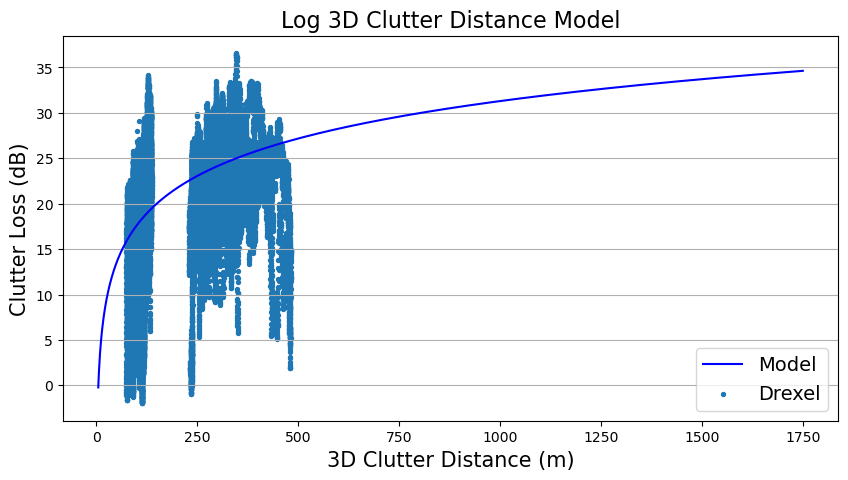

In [32]:
plt.plot(full_x, full_y, label='Model', c='b')

plt.scatter(drexfull_df["clutter_d__meter"], drexfull_df["L_excess__db"], label='Drexel', s=8)

plt.xlabel('3D Clutter Distance (m)', fontsize=15)
plt.ylabel('Clutter Loss (dB)', fontsize=15)
plt.title('Log 3D Clutter Distance Model', fontsize=16)
plt.legend(fontsize=14)
plt.gca().yaxis.grid(True)
plt.show()

In [33]:
# print("\t\t\t\t\t\tMin\tMax\tMean\tSt Dev")

# print("Boulder Downtown - RX elevation angle (deg)\t{:.2f}\t{:.2f}\t{:.2f}\t{:.2f}".format(np.min(bd_df["rx_angle__deg"]),
#                                                                                      np.max(bd_df["rx_angle__deg"]),
#                                                                                      np.mean(bd_df["rx_angle__deg"]),
#                                                                                      np.std(bd_df["rx_angle__deg"])))